In [1]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/Users/bob/anaconda/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
pixels = 900
cm.update('livereveal', {
    'transition': 'convex',
    'start_slideshow_at': 'selected',
    'scroll': True,
    'width': pixels * 16 / 9,
    'height': pixels,
    'controls': False
})

{u'controls': False,
 u'height': 900,
 u'minScale': 0.2,
 u'scroll': True,
 u'start_slideshow_at': 'selected',
 u'theme': u'serif',
 u'transition': 'convex',
 u'width': 1600}

In [2]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (8.0, 6.0)

import json
import datetime
import pytz
import itertools

import pandas as pd
import numpy as np
import networkx as nx

from tabulate import tabulate 

<div><img src="title.png"></div>

501c3 Nonprofit started to connect __Professional and Aspiring Data Scientists__ with problems involving __Social Good__.

- Hackathons
- Meetups

# Anidata 1.x
Collection of hackathons and events focused on helping the Fulton County DA Office prosecute Human Trafficking cases.





# Fulton County DA Human Trafficking Problem
- Internet Ads are used to solicit for human trafficking
- Police, investigators, and DAs often start a case with a snippet of data (a phone number or email address) about a perp
- One challenge is that this information is often fleeting
- Our goal was to help resolve this issue by performing entity resolution (ER) on the contact information contained in Internet ad posts.


<table><tr><td>
<img  src="hackathon.png" width=600px/></td><td><img  src="hackathon2.png" width=600px/></td></tr></table>

# Data
- Scraped several months of ad data from seedy websites
- Columns: 
    - name
    - phone number
    - oid (poster unique ID)
    - posterage
    - region
    - type
- Sample data includes three flat files that pair a `post_id` with an email, user ID, or email address.



## Data Sample

In [7]:
df = pd.read_csv(
    'data/scraped_data.csv.gz',
    converters={'name': lambda x: str(x).lower(),
                'number': str,
                'oid': str,
                'post_id': str},
    parse_dates=['postdate'])
df.head()

,post_id,name,number,oid,postdate,posterage,region,type
0,0,,6242414310,9635571,2015-11-28 12:00:00,19.0,birmingham,Datelines
1,1,,,13957915,2015-12-23 09:13:00,21.0,nashville,Datelines
2,3,,,33808981,2015-12-24 01:03:00,24.0,miami,Datelines
3,4,,3059227034,32821362,2015-12-23 01:51:00,35.0,miami,FemaleEscorts
4,6,,6242414310,16767542,2015-12-18 06:20:00,25.0,tampa,Datelines


## Data Description

In [28]:
df.describe(include = 'all')

,post_id,name,number,oid,postdate,posterage,region,type
count,232920,232920,232920,232920,232920,232868.000000,232920,232920
unique,232920,1319,21933,194721,84966,NaN,18,8
top,217189,,,21070057,2015-11-24 02:17:00,NaN,atlanta,FemaleEscorts
freq,1,228994,72361,110,112,NaN,98439,172444
first,NaN,NaN,NaN,NaN,2012-10-12 12:22:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2016-02-28 12:59:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,25.678316,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,8.096470,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Entity Resolution

After wrestling with the data a bit, we realized that we can conceptualize the data as a graph.

##  Entity Graph
- Vertices: Backpage posts
- Edged: Common attributes (email, phone number, poster ID)


### Explore Subgraph Sizes

In [29]:
df\
.groupby('number')\
.count()\
.sort_values('post_id',ascending=False)[['post_id']]\
.head()

,post_id
number,
,72361
7863556827,1436
4047236489,1336
6242414310,1221
4044511961,945


### Example Sub-Graph
- One challenge is to efficiently create the sub graphs.
- Our first approach was to make fully connected graph out of the data subsets.

Here is an example of a phone number that is seen on 11 posts:

In [30]:

ph_sample = df[df.number=='7865032020']
ph_sample.sort_values('name',ascending=False).head()

,post_id,name,number,oid,postdate,posterage,region,type
220676,221500,tucenicienta360@gmail.com,7865032020,26583449,2015-12-22 10:32:00,21.0,miami,FemaleEscorts
134390,134885,tucenicienta360@gmail.com,7865032020,26659871,2015-12-02 11:52:00,21.0,miami,FemaleEscorts
16418,16500,dallaz360@hotmail.com,7865032020,28354889,2015-12-05 04:57:00,22.0,miami,FemaleEscorts
2276,2304,,7865032020,31811642,2015-12-19 10:44:00,25.0,miami,FemaleEscorts
177430,178083,,7865032020,31857356,2015-12-16 09:53:00,24.0,miami,FemaleEscorts


### Fully Connected

#### Phone Numbers Only

In [54]:
def plot_graph_data(in_data, data_type, color, G=nx.Graph()):
    ''' Plot graph '''
    out = []
    for a, b in itertools.product(in_data, in_data):
        out.append((a, b, {'type': data_type, 'color': color}))
    G.add_edges_from(out)
    pos = nx.circular_layout(G)
    colors = [G[u][v]['color'] for u, v in G.edges()]
    nx.draw(G, pos, node_color='k', edge_color=colors, width=2)
    return G

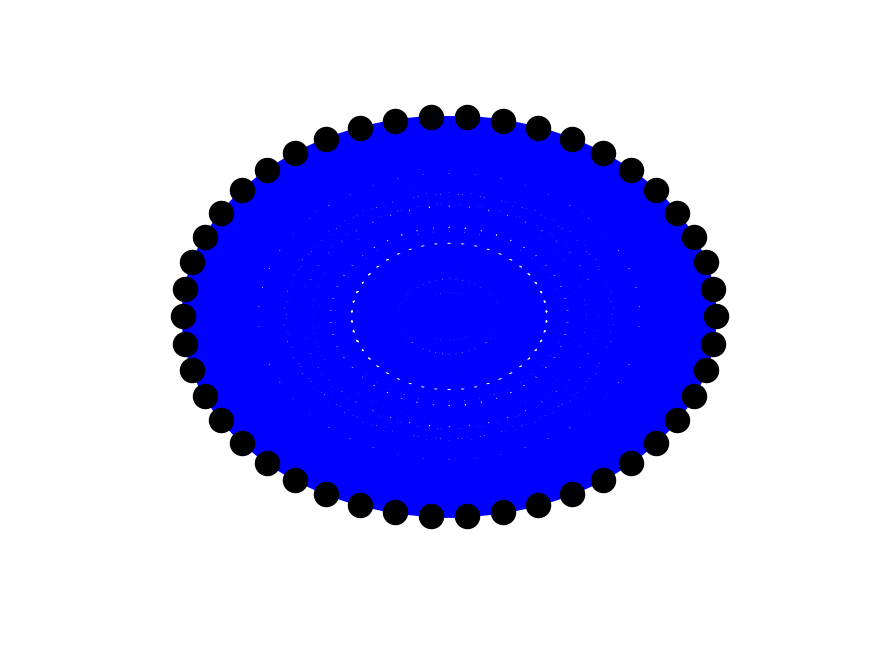

In [67]:
G_samp = plot_graph_data(ph_sample.post_id, 'phone', 'b', G=nx.Graph());

#### Email Addresses Only

In [32]:
em_sample = df[df['name'].str.contains('tuc',False)]
em_sample

,post_id,name,number,oid,postdate,posterage,region,type
2319,2347,tucenicienta360@gmail.com,7866505040,26588406,2015-12-22 10:27:00,22.0,miami,FemaleEscorts
2320,2348,tucenicienta360@gmail.comhref,7866505040,26588406,2015-12-22 10:27:00,22.0,miami,FemaleEscorts
104393,104780,tucenicienta360@gmail.com,7866505040,26577033,2015-12-14 01:38:00,22.0,miami,FemaleEscorts
134390,134885,tucenicienta360@gmail.com,7865032020,26659871,2015-12-02 11:52:00,21.0,miami,FemaleEscorts
220676,221500,tucenicienta360@gmail.com,7865032020,26583449,2015-12-22 10:32:00,21.0,miami,FemaleEscorts


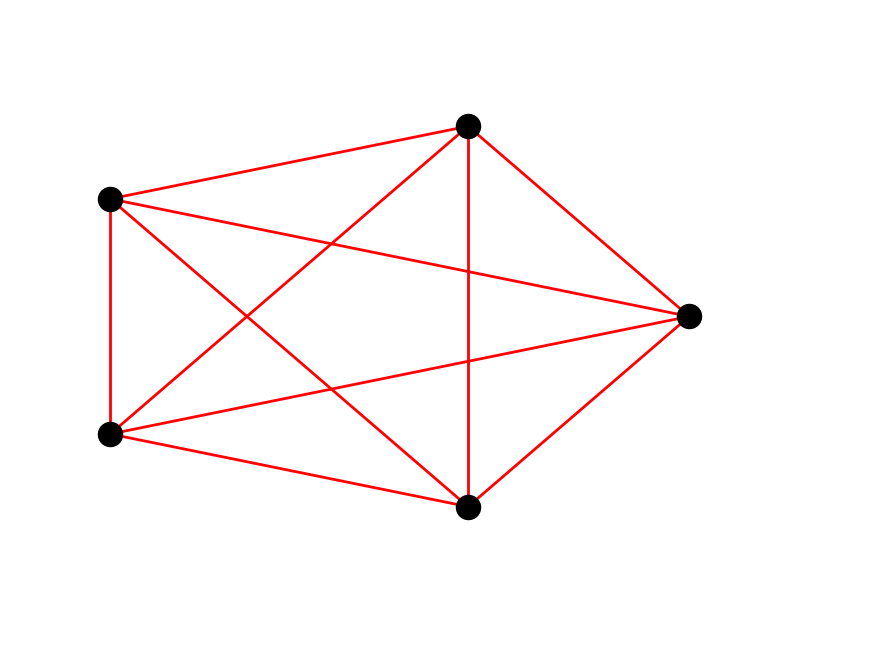

In [68]:
G_samp_em = plot_graph_data(em_sample.post_id, 'email', 'r', G=nx.Graph())

#### Combined Graph with Email and Phone Numbers

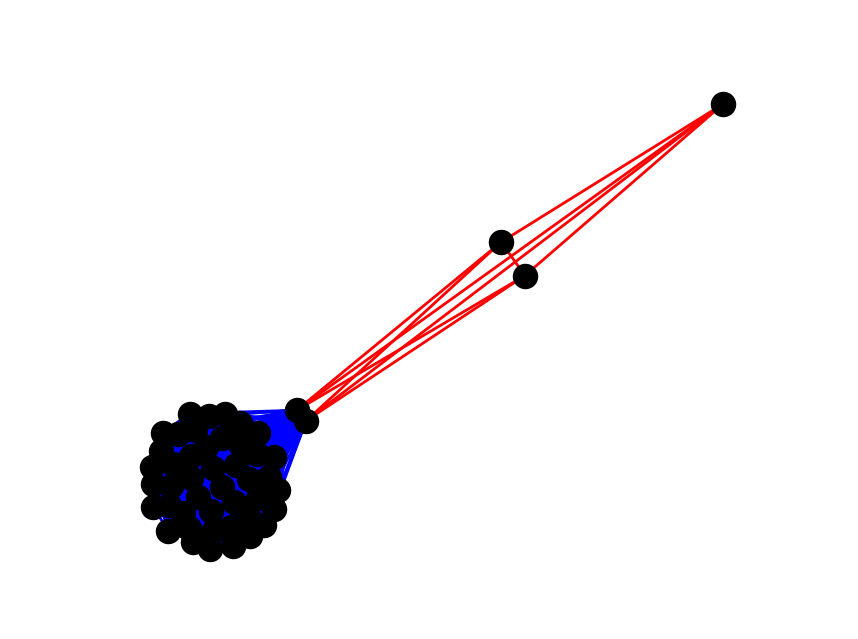

In [70]:
out = []
for a, b in itertools.product(em_sample.post_id, em_sample.post_id):
    out.append((a, b, {'type': 'email', 'color': 'r'}))
    
G_samp.add_edges_from(out)
pos = nx.spring_layout(G_samp)
colors = [G_samp[u][v]['color'] for u, v in G_samp.edges()]
nx.draw(G_samp, pos, node_color='k', edge_color=colors, width=2)

### Simplifying The Graph

- This works, but having a fully connected set of graphs ends up taking a bunch of Memory.
- To simplify, we only need each network of posts to be connected--__not__ fully connected.
- Create a sub-graph that is a loosely connected loop instead.

In [71]:
G_samp_loop = nx.Graph()

# No product for loop
v = ph_sample.post_id.values.tolist()
v_right = v[1:]
if len(v) == 1:
    v_right = v
else:
    v_right[-1] = v[0]
out = [(a, b,{'type':'phone','color':'b'}) for a, b in zip(v, v_right)]

G_samp_loop.add_edges_from(out)
pos = nx.spectral_layout(G_samp_loop)


colors = [G_samp_loop[u][v]['color'] for u,v in G_samp_loop.edges()]

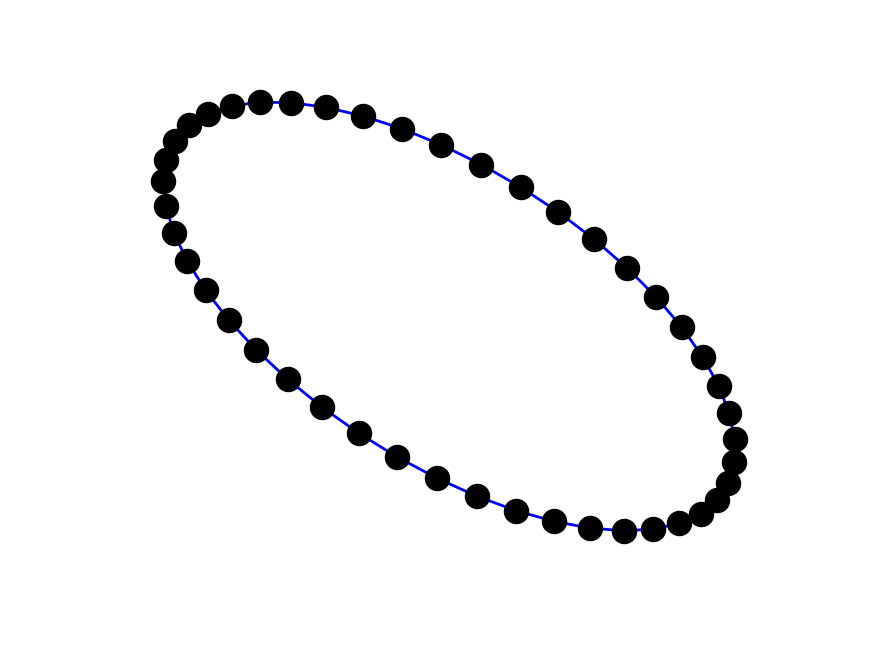

In [72]:
nx.draw(G_samp_loop,pos,node_color='k',edge_color=colors,width=2)

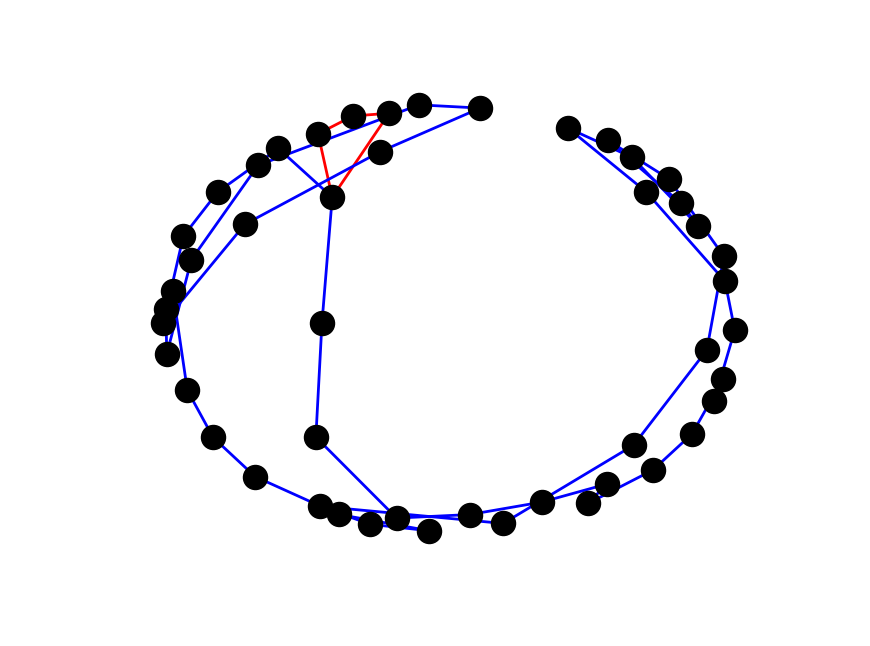

In [73]:
v = em_sample.post_id.values.tolist()
v_right = v[1:]
if len(v) == 1:
    v_right = v
else:
    v_right[-1] = v[0]
out += [(a, b,{'type':'phone','color':'r'}) for a, b in zip(v, v_right)]

G_samp_loop.add_edges_from(out)
pos = nx.spring_layout(G_samp_loop)

colors = [G_samp_loop[u][v]['color'] for u,v in G_samp_loop.edges()]
nx.draw(G_samp_loop,pos,node_color='k',edge_color=colors,width=2)


## Graph Clusters
When viewed this way, a set of connected posts (vertices) and poster attributes (edges) constitute an entity.

## Approach
1. Make a graph out of the data using these ideas
1. Find all of the disjoint subgraphs and designate those as entities

In [37]:
def make_graph(df, color, data_type):
    '''
    Makes a list of tuple lists for each node-edge-node segment in the graph
    '''
    out = []
    for i, (k, v) in enumerate(df.groupby(df.columns[-1])):
        
        v = v.values.tolist()
        v = [x[0] for x in v]
        v_right = v[1:]
        if len(v) == 1:
            v_right = v
        else:
            v_right[-1] = v[0]
        out.append([(a, b, {'type': data_type,
                            'color': color}) for a, b in zip(v, v_right)])
    out = [item for sublist in out for item in sublist]
    return out

### Add Graphs for Each Type of Connection

In [38]:
out = make_graph(df[df.name!=''][['post_id','name']],'r','email')
out += make_graph(df[df.number!=''][['post_id','number']],'b','number')
out += make_graph(df[df.oid!=''][['post_id','oid']],'g','oid')

### Use NetworkX to Find Disjoint SubGraphs

In [39]:
G = nx.Graph()
G.add_edges_from(out)

sub_graphs = []
for i, x in enumerate(nx.connected_component_subgraphs(G)):
    nodes = nx.nodes(x)
    sub_graphs.append(list(zip([i] * len(nodes), nodes)))

sub_graphs = [item for sublist in sub_graphs for item in sublist]



### Check Entity Data

In [40]:
df_out = pd.DataFrame(sub_graphs,
                      columns=['entity_id',
                               'post_id'])
df_out.head(10)

,entity_id,post_id
0,0,228056
1,1,228051
2,2,228050
3,3,228053
4,4,228052
5,5,90828
6,5,134739
7,5,228059
8,5,65347
9,5,6603


### Merge With Original Data

And we are done...

In [41]:

df_out = df_out.merge(df,on='post_id')
df_out.set_index(['entity_id','number','name','oid'],inplace=True)
df_out.head(10)

post_id            postdate  posterage  \
entity_id number     name oid                                               
0                         19170225  228056 2016-02-27 12:45:00       23.0   
1         8132700180      19122423  228051 2016-02-24 07:44:00       26.0   
2         7277127655      14116170  228050 2016-02-24 12:18:00       62.0   
3         8136662555      17199891  228053 2016-02-25 03:22:00       22.0   
4         7273419926      11032214  228052 2016-02-27 10:25:00       99.0   
5         8133476501      14028137   90828 2015-12-22 09:27:00       25.0   
                          16283312  134739 2015-12-23 01:10:00       25.0   
                          14028137  228059 2016-02-27 03:14:00       26.0   
                          16283312   65347 2016-02-02 02:10:00       26.0   
                          14028137    6603 2016-02-02 12:54:00       26.0   

                                   region                type  
entity_id number     name oid                                  
0                         19170225  tampa       FemaleEscorts  
1         8132700180      19122423  tampa  TranssexualEscorts  
2         7277127655      14116170  tampa          Domination  
3         8136662555      17199891  tampa  TranssexualEscorts  
4         7273419926      11032214  tampa  TranssexualEscorts  
5         8133476501      14028137  tampa       FemaleEscorts  
                          16283312  tampa       FemaleEscorts  
                          14028137  tampa       FemaleEscorts  
                          16283312  tampa            BodyRubs  
                          14028137  tampa          Domination

# Check Results

## Check Email

In [42]:
df_out.xs('tucenicienta360@gmail.com',level='name')

post_id            postdate  posterage region  \
entity_id number     oid                                                      
560       7866505040 26588406    2347 2015-12-22 10:27:00       22.0  miami   
          7865032020 26659871  134885 2015-12-02 11:52:00       21.0  miami   
                     26583449  221500 2015-12-22 10:32:00       21.0  miami   
          7866505040 26577033  104780 2015-12-14 01:38:00       22.0  miami   

                                        type  
entity_id number     oid                      
560       7866505040 26588406  FemaleEscorts  
          7865032020 26659871  FemaleEscorts  
                     26583449  FemaleEscorts  
          7866505040 26577033  FemaleEscorts

In [43]:
G['104780']

{'104780': {'color': 'g', 'type': 'oid'},
 '104876': {'color': 'b', 'type': 'number'},
 '134885': {'color': 'r', 'type': 'email'},
 '2347': {'color': 'r', 'type': 'email'},
 '46482': {'color': 'b', 'type': 'number'}}

## Check Entity

In [44]:
df_out.loc[560].sort_index()

post_id            postdate  \
number     name                          oid                                    
7865032020                               26577332   90113 2015-12-08 05:25:00   
                                         27978380   31818 2015-12-22 12:56:00   
                                         28372705   20101 2016-01-08 02:16:00   
                                         28561650   52095 2016-01-25 10:17:00   
                                         28561650  147990 2015-12-22 10:29:00   
                                         31300988  122688 2016-01-18 10:59:00   
                                         31300988  207134 2015-12-24 10:34:00   
                                         31467113    2406 2015-12-24 10:27:00   
                                         31810842    2409 2015-12-24 10:32:00   
                                         31811642    2304 2015-12-19 10:44:00   
                                         31814749  163166 2015-12-02 11:54:00   
                                         31831488  134051 2015-12-18 12:52:00   
                                         31837041  221367 2015-12-05 04:52:00   
                                         31837101  119466 2015-12-17 02:56:00   
                                         31837906  163315 2015-12-18 11:00:00   
                                         31838170   46451 2015-12-22 10:30:00   
                                         31854569  119535 2015-12-23 11:52:00   
                                         31855380   75795 2015-12-22 01:12:00   
                                         31856096  163422 2015-12-24 10:27:00   
                                         31856922   31784 2015-12-19 11:52:00   
                                         31857356  178083 2015-12-16 09:53:00   
                                         31862500  195857 2016-01-15 05:24:00   
                                         31862500  221467 2015-12-19 02:31:00   
                                         31864686  124252 2016-02-13 03:57:00   
                                         31864686  221544 2015-12-24 10:33:00   
                                         31878332  134159 2015-12-24 10:33:00   
                                         33495618  206457 2015-12-08 05:23:00   
                                         33889430  138814 2016-02-13 03:58:00   
                                         33889430  148610 2015-12-23 11:48:00   
                                         33889585   61000 2015-12-21 10:35:00   
...                                                   ...                 ...   
                                         34172650  192610 2015-12-08 05:24:00   
                                         34172870   60936 2015-12-16 04:29:00   
                                         35289414  181047 2016-01-16 10:03:00   
                                         35289414   45955 2015-12-24 10:32:00   
                                         36808973   22751 2016-02-10 01:38:00   
           dallaz360@hotmail.com         28354889   16500 2015-12-05 04:57:00   
           tucenicienta360@gmail.com     26583449  221500 2015-12-22 10:32:00   
                                         26659871  134885 2015-12-02 11:52:00   
7866505040                               28372705   20100 2016-01-08 02:16:00   
                                         28384098   16562 2015-12-17 11:28:00   
                                         31331761  119485 2015-12-19 11:51:00   
                                         31811398  206968 2015-12-09 10:51:00   
                                         31828798  207132 2015-12-24 10:35:00   
                                         31831778  148590 2015-12-22 10:30:00   
                                         31835789   46453 2015-12-22 12:56:00   
                                         31840012   46482 2015-12-23 02:42:00   
                                         31859247  104876 2015-12-23 02:47:00   


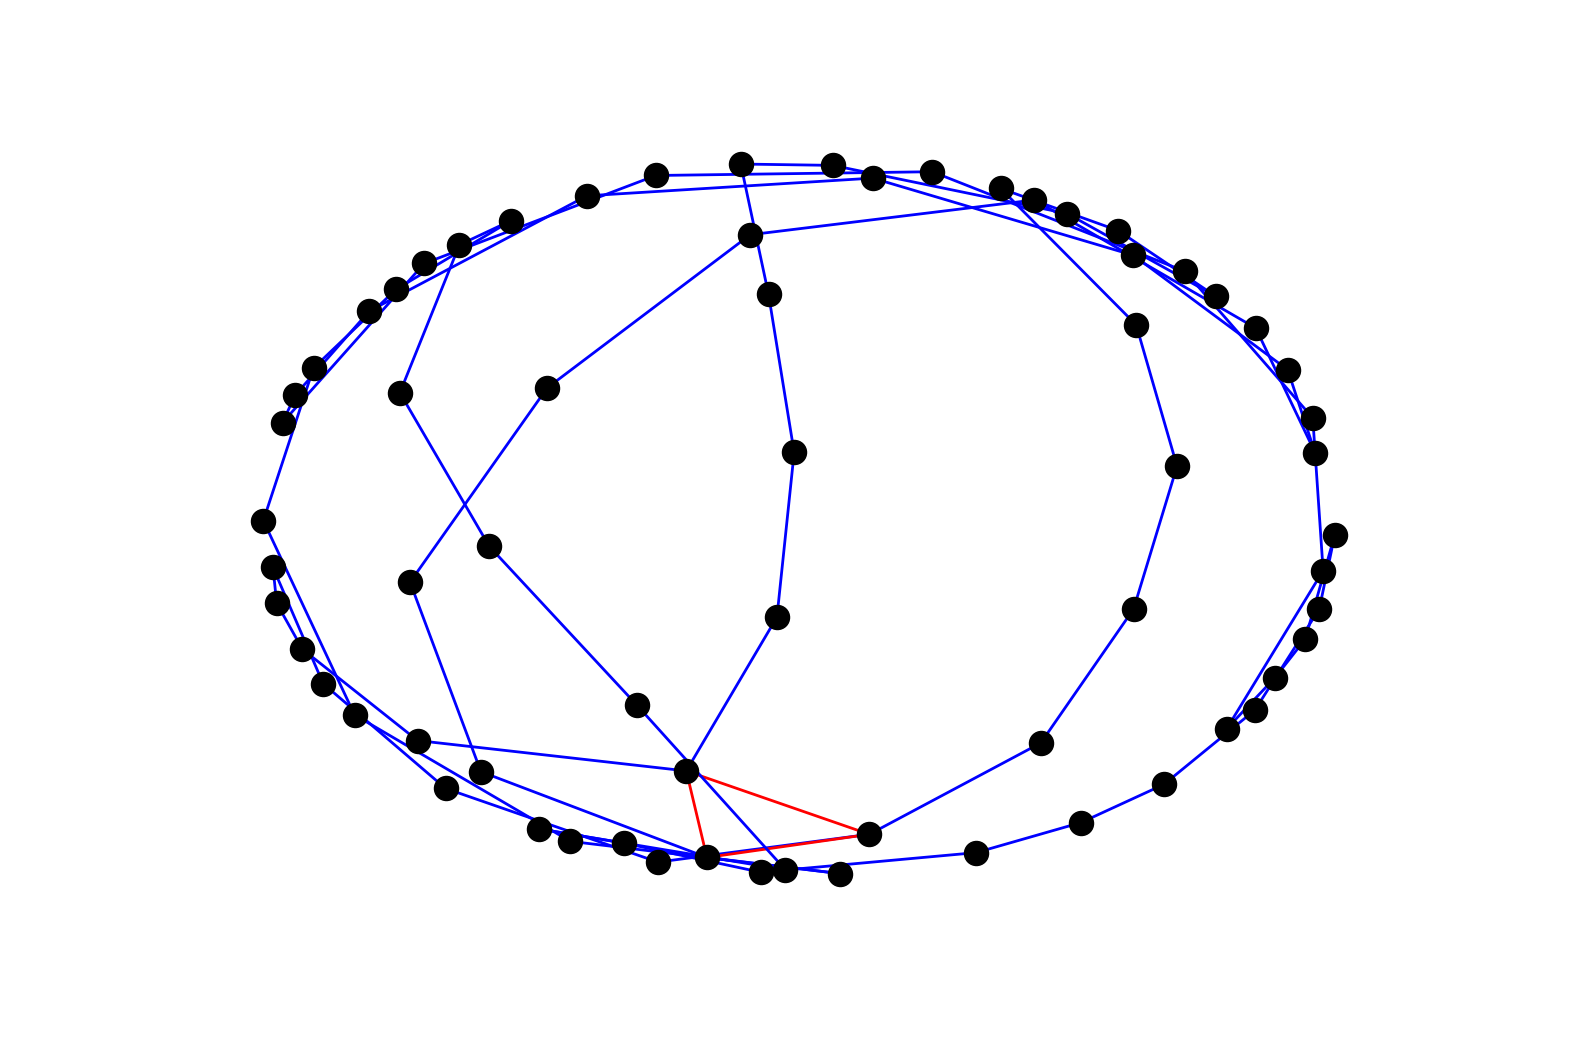

In [53]:
G_check = G.subgraph(df_out.loc[560].post_id.values)

pos = nx.spring_layout(G_check)


colors = [G_check[u][v]['color'] for u,v in G_check.edges()]
nx.draw(G_check,pos,node_color='k',edge_color=colors,width=2)